In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

from os.path import isfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

from model.utils import get_device, generate_predictions

from data_processing.pipeline import encoding_pipeline, get_generic_name

from model.rnn import GRUDecoder
from model.autoencoder import SimpleAutoEncoder
from model.autoencoder import TabularEncoder

from model.dataset import PretrainingDataset

In [2]:
device = get_device()
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')
importance = pd.read_csv('data/feature_importance/features_importance_xgboost.csv')

Using MPS (Metal Performance Shaders) device


# What is the effect of increasing the number of questions?

## Pretraining
I do pretraining on all the data. The pretraining is currently done with the convolutional autoencoder. 

## Finetuning
We perform 5-fold cross validation for the FT. One fold is used for testing, one fold is used for early stopping (I have experienced that we overfit quickly), and the remaining 3 are used for training.



### Pretraining

In [3]:
# set parameters for the PT
PT_BATCH_SIZE = 128
PT_HIDDEN_SIZE = 64
PT_ENCODING_SIZE = 64
PT_NUM_HEADS = 4
PT_NUM_LAYERS = 3

assert PT_HIDDEN_SIZE % PT_NUM_HEADS == 0, "Check that the hidden size is divisible"

PT_num_epochs = 15
PT_learning_rate = 1e-4

# small number of questions
n_questions = [50, 100, 500, 1000]

# large number of questions (here I have memory issues)
#n_questions = [5000, 10000, -1]

PT_base_model_path = model_name = f"saturation_test_PT_nquestions"

In [4]:
all_train_loss = []   # for plotting
n_cols_list = []

for n_quest in n_questions:
    model_name = PT_base_model_path + '_' + str(n_quest)
    
    print(model_name)
    if True:# not isfile(f'weights/{model_name}_{PT_num_epochs}.pt'):

        custom_pairs = importance.iloc[:n_quest].feature.map(lambda x: get_generic_name(x))
        n_cols = len(set(custom_pairs))

        print(f'Number of questions: {n_quest}, question pr. year {n_cols}')
        
        sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
        pretrain_dataset = PretrainingDataset(sequences)

        SEQ_LEN = pretrain_dataset.get_seq_len()
        VOCAB_SIZE = pretrain_dataset.get_vocab_size()
        
        encoder = TabularEncoder(vocab_size=VOCAB_SIZE, embedding_size=PT_HIDDEN_SIZE, output_size=PT_ENCODING_SIZE, 
                                 num_heads=PT_NUM_HEADS, num_layers=PT_NUM_LAYERS, sequence_len=SEQ_LEN, 
                                 layer_type = "mixture", dropout=0.25, decoder_output=3).to(device)
        
        loss_cls = nn.CrossEntropyLoss(label_smoothing=0.01).to(device)
        optimizer = optim.RAdam(encoder.parameters(), lr = PT_learning_rate, weight_decay=1e-3, decoupled_weight_decay=True)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = PT_num_epochs, eta_min = 1e-5, last_epoch = -1)
        
        train_dataloader = DataLoader(pretrain_dataset, batch_size=PT_BATCH_SIZE, shuffle=True)

        loss_metric = []
        encoder.train()
        for epoch in range(PT_num_epochs):
            loss_epoch_metric = []
            loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
            for i, (year, seq) in loop_object :
                optimizer.zero_grad()
                year = year.to(device)
                input_seq = seq.to(device)

                seq, targs = generate_predictions(input_seq, vocab_size = VOCAB_SIZE, p = 0.3, missing_token_id=101)
                x = encoder.forward(year = year, seq=seq)

                loss = loss_cls(x.permute(0,2,1), targs.long())
                
                # store loss for plotting
                loss_epoch_metric.append(loss.detach().cpu().numpy())
                all_train_loss.append(loss_epoch_metric[-1])
                n_cols_list.append(n_cols)

                loss.backward()
                optimizer.step()
                loop_object.set_postfix_str("mean loss: %.4f"%np.mean(loss_epoch_metric[-100:]))

            ## After epoch end
            scheduler.step()
            loss_metric.append(np.mean(loss_epoch_metric))
            print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')
            
        torch.save(encoder.state_dict(), f'weights/{model_name}_{PT_num_epochs}.pt')

        print('')

saturation_test_PT_nquestions_5000
Number of questions: 5000, question pr. year 1724


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


1716
Embedding Layer with Question Embdeddings


/Users/lmmi/fertility-prediction-challenge/model/embeddings.py:38: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.question_embedding.weight)
Epochs 0: 0it [00:10, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 29.30 GB, other allocations: 5.64 GB, max allowed: 36.27 GB). Tried to allocate 5.62 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

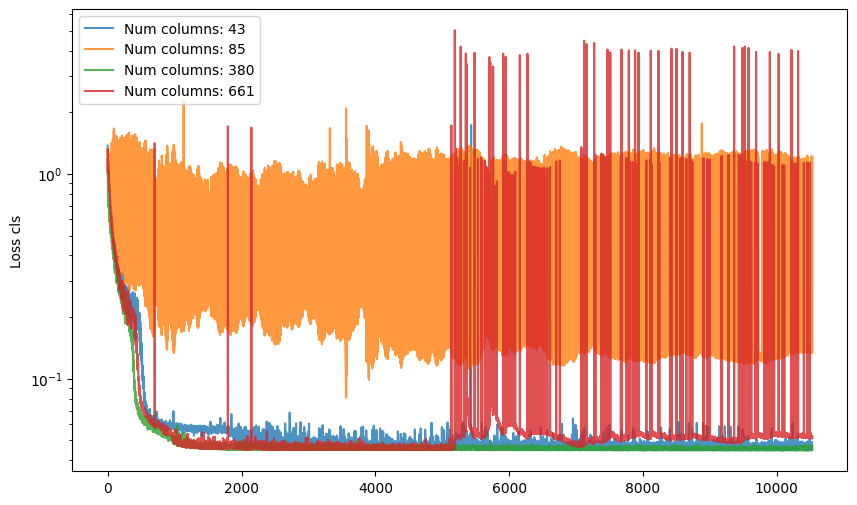

In [101]:
grouped_data = {}

for i, col in enumerate(n_cols_list):
    if col not in grouped_data:
        grouped_data[col] = []
    grouped_data[col].append(all_train_loss[i])


plt.figure(figsize=(10, 6))

for i, (col, loss_values) in enumerate(grouped_data.items()):
    plt.plot(loss_values, label=f'Num columns: {col}', color = 'C' + str(i), alpha = 0.8)

plt.ylabel('Loss cls')
plt.yscale('log')
plt.legend()
plt.show()

### Finetuning


The current setup does not do any cross-validation. Germans seems to have implemented it in train_experimental. Check it out and implement it for the cross-val

In [154]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from model.dataset import FinetuningDataset

# load arguments for the fine-runing
FT_BATCH_SIZE = 16
FT_ENCODING_SIZE = 64
FT_HIDDEN_SIZE = 64
FT_NUM_LAYERS = 2
FT_LEARNING_RATE= 5e-3
FT_NUM_EPOCHS = 10
k_folds = 5
FT_base_model_path = model_name = f"saturation_test_FT_nquestions"

# restrict target df to ones where we have target
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
targets = targets[targets.new_child.notna()].reset_index(drop=True)

In [145]:
import re
import os

def get_statedict(model_name, directory='weights', max_epoch=False):
    """
    Loads state dict for the pretrained encoder.
    
    Can either take model name in format 
        model_name=base_model_path + '_' + str(n_quest)
    with max_epoch=True or 
        model_name='weights/{model_name}_{PT_num_epochs}.pt' 
    with max_epoch=False. If max_epoch=True, then the function finds the 
    saved state dict for the max number of epochs with the given number
    of collumns (n_quest) 
    """

    # Regular expression to match the file format and extract the epoch number
    
    if max_epoch: #find model trained on the most epochs
        pattern = re.compile(rf'{model_name}_(\d+)\.pt')
        
        max_epoch = -1
        latest_model_path = None
        
        # Iterate over all files in the directory
        for filename in os.listdir(directory):
            # Check if the filename matches the pattern
            match = pattern.match(filename)
            if match:
                # Extract the epoch number
                epoch = int(match.group(1))
                # Update the latest model path if this epoch is the highest so far
                if epoch > max_epoch:
                    max_epoch = epoch
                    latest_model_path = os.path.join(directory, filename)
        
        # Load the model from the latest model path
        if latest_model_path:
            state_dict = torch.load(latest_model_path)
            print(f"Loaded model from {latest_model_path}")
            return state_dict
        else:
            raise FileNotFoundError(f"No model files found for {model_name} in {directory}")
        
    else:
        model_path = os.path.join(directory, model_name + '.pt')
        state_dict = torch.load(model_path)
        return state_dict

In [146]:
def load_autoencoder(autoencoder_path, eval = True):
    encoder_state_dict= get_statedict(model_name=autoencoder_path, max_epoch=False)
    encoder = TabularEncoder(vocab_size=VOCAB_SIZE, embedding_size=PT_HIDDEN_SIZE, 
                              output_size=PT_ENCODING_SIZE, num_heads=PT_NUM_HEADS,
                              num_layers=PT_NUM_LAYERS, sequence_len=SEQ_LEN, 
                              layer_type = "mixture", dropout=0.25, decoder_output=3).to(device)

    encoder.load_state_dict(state_dict=encoder_state_dict)

    if eval:
        encoder.eval()
    
    return encoder

In [147]:
def load_rnn(rnn_path, eval = True):
    decoder_state_dict= get_statedict(model_name=rnn_path, max_epoch=False)
    decoder = GRUDecoder(input_size=FT_ENCODING_SIZE, hidden_size=FT_HIDDEN_SIZE, num_layers=FT_NUM_LAYERS,
                        max_seq_len=14, dropout=0.3, bidirectional=False, with_attention = True).to(device)

    decoder.load_state_dict(state_dict=decoder_state_dict)

    if eval:
        decoder.eval()
    
    return decoder

In [148]:
#implementation of a simple early stopper
# if the previously reported val loss is below the current, we stop
# in the test below we use mean loss over val set
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [150]:
# reararanging data for the fine tuning and pretraining
def create_ft_data(sequences, device):
    rnn_data = {
        person_id: (
            torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
            torch.tensor([wave_response for _, wave_response in wave_responses.items()]).to(device)
            )
            for person_id, wave_responses in sequences.items()
    }
    return rnn_data


def create_pt_data(importance, n_quest, data, codebook):
    custom_pairs = importance.iloc[:n_quest].feature.map(lambda x: get_generic_name(x))
    n_cols = len(set(custom_pairs))
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    pretrain_dataset = PretrainingDataset(sequences)
    
    return sequences, pretrain_dataset, n_cols

In [161]:
import torch
import numpy

# training and validation loops

def train_one_epoch(dataloader, decoder, encoder, epoch, ft_optimizer, ft_scheduler, ft_loss):
    loop_object  = tqdm(enumerate(dataloader), desc=f"Epochs {epoch}")

    for i, batch in loop_object :        

        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()

        outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

        loss = ft_loss(torch.flatten(outputs), labels)  

        loss.backward()
        ft_optimizer.step()

    # On epoch end
    ft_scheduler.step()

def validate_one_epoch(dataloader, decoder, encoder, ft_loss):
    # returns the mean loss over the epoch
    loop_object  = tqdm(enumerate(dataloader))
    
    loss_list = []

    with torch.no_grad():
        for i, batch in loop_object :        
            inputs, labels = batch
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
            mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()

            # Forward pass
            outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

            loss = ft_loss(torch.flatten(outputs), labels).detach().cpu().numpy()  
            loss_list.append(loss)

    return np.mean(loss_list)


In [162]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_ft(dataloader, encoder, decoder):
    # get true and predicted labels for given encoder-decoder pair
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings = encoder.get_encoding(input_year, input_seq).view(bs, ss, -1)
            mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs, ss).detach()

            outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

            all_labels.append(labels.cpu().numpy())
            all_outputs.append(torch.flatten(outputs).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    
    return all_labels, all_outputs

def calculate_metrics(labels, outputs):
    # calculate acc, prec, recall, and f1
    preds = outputs > 0.5
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return accuracy, precision, recall, f1


In [176]:
# lists for plotting
train_acc_list = []
train_prec_list = []
train_rec_list = []
train_f1_list = []

test_acc_list = []
test_prec_list = []
test_rec_list = []
test_f1_list = []

n_question_list = []
n_col_list = []

# cross validation
ft_loss = nn.BCELoss()
n_splits = 5  # or any number >= 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# loop over n-questions (number of cols from importance to use)
for n_quest in n_questions:

    # prep data
    sequences, pretrain_dataset, n_cols = create_pt_data(importance, n_quest, data, codebook)
    SEQ_LEN = pretrain_dataset.get_seq_len()
    VOCAB_SIZE = pretrain_dataset.get_vocab_size()
    
    rnn_data = create_ft_data(sequences, device)
    
    # load autoencoder
    autoencoder_name= PT_base_model_path + '_' + str(n_quest)
    autoencoder_path = f'{autoencoder_name}_{PT_num_epochs}' 
    encoder = load_autoencoder(autoencoder_path, eval = True)

    decoder = GRUDecoder(input_size=FT_ENCODING_SIZE, hidden_size=FT_HIDDEN_SIZE, num_layers=FT_NUM_LAYERS,
                        max_seq_len=14, dropout=0.3, bidirectional=False, with_attention = True).to(device)
    decoder.train()

    # Define loss function and optimizer for RNN
    ft_optimizer = torch.optim.NAdam(list(decoder.parameters()), lr=FT_LEARNING_RATE,
                                     weight_decay=1e-2, decoupled_weight_decay=True)
    ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = FT_NUM_EPOCHS,
                                                        eta_min = 1e-6, last_epoch = -1)

    # k-fold cross validation    
    for fold, (train_val_ids, test_ids) in enumerate(kfold.split(targets.nomem_encr, targets.new_child)):
        
        # splitting data
        train_ids, val_ids = train_test_split(train_val_ids, test_size=0.25, random_state=42)

        train_data = {person_id: rnn_data[person_id] for person_id in targets.iloc[train_ids].nomem_encr}
        val_data =   {person_id: rnn_data[person_id] for person_id in targets.iloc[val_ids].nomem_encr}
        test_data =  {person_id: rnn_data[person_id] for person_id in targets.iloc[test_ids].nomem_encr}
        
        # initialize early stopper
        early_stopper = EarlyStopper(patience=1, min_delta=1e-5)

        # prepare the data for finetuning
        train_dataset = FinetuningDataset(train_data, targets = targets)
        val_dataset   = FinetuningDataset(val_data, targets = targets)
        test_dataset  = FinetuningDataset(test_data,  targets = targets)

        train_dataloader = DataLoader(train_dataset, batch_size=FT_BATCH_SIZE, shuffle=True)
        val_dataloader   = DataLoader(train_dataset, batch_size=FT_BATCH_SIZE)
        test_dataloader  = DataLoader(test_dataset,  batch_size=FT_BATCH_SIZE)

        # train for an epoch 
        for epoch in range(FT_NUM_EPOCHS):
            train_one_epoch(train_dataloader, decoder, encoder, epoch, ft_optimizer, ft_scheduler, ft_loss)

            validation_loss = validate_one_epoch(val_dataloader, decoder, encoder, ft_loss)
            if early_stopper.early_stop(validation_loss):
                break

        # evaluate and check for saturation on eval set
        train_labels, train_outputs = evaluate_ft(train_dataloader, encoder, decoder)
        test_labels, test_outputs   = evaluate_ft(test_dataloader, encoder, decoder)

        train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_labels, train_outputs)
        test_acc, test_prec, test_rec, test_f1 = calculate_metrics(test_labels, test_outputs)

        train_acc_list.append(train_acc)
        train_prec_list.append(train_prec)
        train_rec_list.append(train_rec)
        train_f1_list.append(train_f1)

        test_acc_list.append(test_acc)
        test_prec_list.append(test_prec)
        test_rec_list.append(test_rec)
        test_f1_list.append(test_f1)
        
        n_question_list.append(n_quest)
        n_col_list.append(n_cols)

    

/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


Embedding Layer with Question Embdeddings


Epochs 0: 37it [00:05,  6.44it/s]
37it [00:01, 23.11it/s]
Epochs 1: 37it [00:05,  6.57it/s]
37it [00:01, 22.98it/s]
Epochs 2: 37it [00:05,  6.58it/s]
37it [00:01, 23.34it/s]
Epochs 0: 37it [00:05,  6.45it/s]
37it [00:01, 23.16it/s]
Epochs 1: 37it [00:05,  6.53it/s]
37it [00:01, 24.35it/s]
Epochs 2: 37it [00:04,  7.60it/s]
37it [00:01, 27.49it/s]
Epochs 0: 37it [00:04,  7.89it/s]
37it [00:01, 28.62it/s]
Epochs 1: 37it [00:04,  8.12it/s]
37it [00:01, 28.32it/s]
Epochs 2: 37it [00:04,  8.05it/s]
37it [00:01, 28.56it/s]
Epochs 0: 37it [00:04,  8.11it/s]
37it [00:01, 28.25it/s]
Epochs 1: 37it [00:04,  7.93it/s]
37it [00:01, 27.74it/s]
Epochs 2: 37it [00:04,  8.04it/s]
37it [00:01, 28.44it/s]
Epochs 0: 37it [00:04,  7.99it/s]
37it [00:01, 29.06it/s]
Epochs 1: 37it [00:04,  8.22it/s]
37it [00:01, 29.15it/s]
Epochs 2: 37it [00:04,  8.29it/s]
37it [00:01, 29.36it/s]
/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:32: SettingWithCopyWarning: 
A value is trying to be set on

Embedding Layer with Question Embdeddings


Epochs 0: 37it [00:06,  5.51it/s]
37it [00:01, 27.03it/s]
Epochs 1: 37it [00:05,  6.34it/s]
37it [00:01, 27.70it/s]
Epochs 0: 37it [00:05,  6.25it/s]
37it [00:01, 28.08it/s]
Epochs 1: 37it [00:05,  6.30it/s]
37it [00:01, 27.83it/s]
Epochs 0: 37it [00:05,  6.29it/s]
37it [00:01, 27.49it/s]
Epochs 1: 37it [00:05,  6.36it/s]
37it [00:01, 27.29it/s]
Epochs 0: 37it [00:05,  6.26it/s]
37it [00:01, 27.57it/s]
Epochs 1: 37it [00:05,  6.21it/s]
37it [00:01, 27.84it/s]
Epochs 2: 37it [00:05,  6.27it/s]
37it [00:01, 26.58it/s]
Epochs 0: 37it [00:05,  6.33it/s]
37it [00:01, 27.40it/s]
Epochs 1: 37it [00:05,  6.28it/s]
37it [00:01, 28.04it/s]
Epochs 2: 37it [00:05,  6.36it/s]
37it [00:01, 27.83it/s]
/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Embedding Layer with Question Embdeddings


Epochs 0: 37it [00:22,  1.63it/s]
37it [00:03,  9.96it/s]
Epochs 1: 37it [00:20,  1.80it/s]
37it [00:03,  9.92it/s]
Epochs 2: 37it [00:20,  1.82it/s]
37it [00:03,  9.82it/s]
Epochs 0: 37it [00:20,  1.80it/s]
37it [00:03,  9.77it/s]
Epochs 1: 37it [00:20,  1.80it/s]
37it [00:03,  9.84it/s]
Epochs 2: 37it [00:20,  1.77it/s]
37it [00:03,  9.88it/s]
Epochs 0: 37it [00:20,  1.78it/s]
37it [00:03,  9.32it/s]
Epochs 1: 37it [00:21,  1.76it/s]
37it [00:03,  9.64it/s]
Epochs 0: 37it [00:21,  1.73it/s]
37it [00:03,  9.69it/s]
Epochs 1: 37it [00:21,  1.74it/s]
37it [00:03,  9.75it/s]
Epochs 0: 37it [00:21,  1.75it/s]
37it [00:03,  9.96it/s]
Epochs 1: 37it [00:20,  1.77it/s]
37it [00:03,  9.71it/s]
/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Embedding Layer with Question Embdeddings


Epochs 0: 37it [00:43,  1.19s/it]
37it [00:08,  4.22it/s]
Epochs 1: 37it [00:43,  1.19s/it]
37it [00:10,  3.43it/s]
Epochs 2: 37it [00:43,  1.17s/it]
37it [00:08,  4.23it/s]
Epochs 0: 37it [00:46,  1.25s/it]
37it [00:07,  4.65it/s]
Epochs 1: 37it [00:40,  1.10s/it]
37it [00:08,  4.44it/s]
Epochs 2: 37it [00:40,  1.10s/it]
37it [00:08,  4.31it/s]
Epochs 0: 37it [00:40,  1.09s/it]
37it [00:08,  4.55it/s]
Epochs 1: 37it [00:40,  1.09s/it]
37it [00:08,  4.61it/s]
Epochs 2: 37it [00:40,  1.09s/it]
37it [00:08,  4.52it/s]
Epochs 0: 37it [00:42,  1.14s/it]
37it [00:08,  4.50it/s]
Epochs 1: 37it [00:40,  1.09s/it]
37it [00:08,  4.52it/s]
Epochs 2: 37it [00:40,  1.08s/it]
37it [00:08,  4.45it/s]
Epochs 0: 37it [00:39,  1.07s/it]
37it [00:08,  4.35it/s]
Epochs 1: 37it [00:39,  1.07s/it]
37it [00:08,  4.42it/s]
Epochs 2: 37it [00:39,  1.08s/it]
37it [00:08,  4.58it/s]


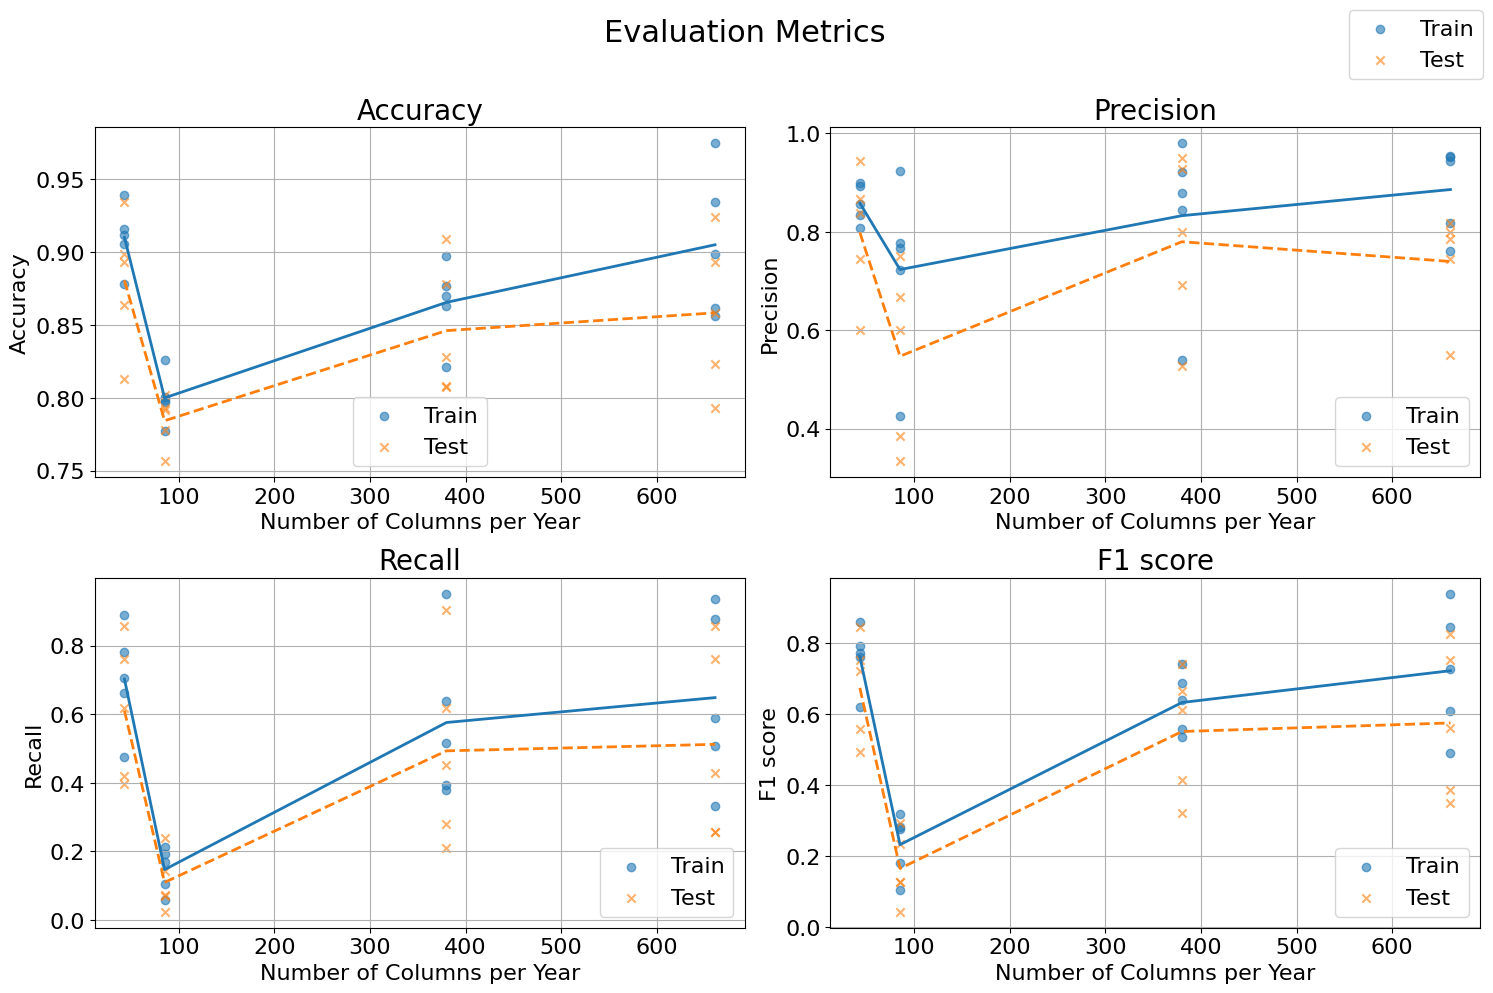

In [181]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your results dataframe
results = pd.DataFrame({
    'Train accuracy': train_acc_list,
    'Train precision': train_prec_list,
    'Train recall': train_rec_list,
    'Train f1 score': train_f1_list,
    'Test accuracy': test_acc_list,
    'Test precision': test_prec_list,
    'Test recall': test_rec_list,
    'Test f1 score': test_f1_list,
    'Number of questions': n_question_list,
    'Number of columns pr. year': n_col_list,
})

results.to_csv(f'results/saturation_results_pt-epochs_{PT_num_epochs}_ft-epochs_{FT_NUM_EPOCHS}.csv')


# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Evaluation Metrics', fontsize=22)

metrics = ['accuracy', 'precision', 'recall', 'f1 score']
train_metrics = [f'Train {metric}' for metric in metrics]
test_metrics = [f'Test {metric}' for metric in metrics]

for i, metric in enumerate(metrics):
    train_metric = train_metrics[i]
    test_metric = test_metrics[i]
    ax = axs[i // 2, i % 2]

    # Scatter plots for individual observations
    ax.scatter(results['Number of columns pr. year'], results[train_metric], label='Train', color='C0', marker='o', alpha=0.6)
    ax.scatter(results['Number of columns pr. year'], results[test_metric], label='Test', color='C1', marker='x', alpha=0.6)
    
    # Lines connecting mean values
    train_means = results.groupby('Number of columns pr. year')[train_metric].mean()
    test_means = results.groupby('Number of columns pr. year')[test_metric].mean()
    ax.plot(train_means.index, train_means.values, color='C0', linestyle='-', linewidth=2)
    ax.plot(test_means.index, test_means.values, color='C1', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Number of Columns per Year', fontsize=16)
    ax.set_ylabel(metric.capitalize(), fontsize=16)
    ax.set_title(metric.capitalize(), fontsize=20)
    ax.legend(fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=16)

# Add a single legend for the entire figure
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Old tests

In [ ]:
def finetune(num_epochs_ft, train_dataloader, autoencoder, decoder, ft_loss, ft_optimizer, aggregator, num_cols):
    for epoch in range(num_epochs_ft):
        # print(epoch)
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, batch in loop_object :        
            ft_optimizer.zero_grad() 
            inputs, labels = batch
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
            encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
            mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

            # Forward pass
            xx = decoder(encodings, mask)
            outputs = F.sigmoid(xx)

            loss = ft_loss(torch.flatten(outputs), labels)  

            #loss.backward(retain_graph=True)
            loss.backward()
            ft_optimizer.step()

In [ ]:
def evaluate(dataloader, encoder, decoder, num_cols, aggregator):
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode
    decoder.eval()
    encoder.eval()
    for batch in dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
        mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = torch.nn.functional.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())


    # Concatenate all the batches
    predictions = (torch.tensor(preds) > 0.5).float()
    probs = F.sigmoid(predictions)
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    
    return precision, recall, f1, map_roc

In [ ]:
PT_HIDDEN_DIM=128
PT_BATCH_SIZE=128
PT_NUM_EPOCHS=5
PT_LEARNING_RATE=10e-2

FT_BATCH_SIZE = 16
FT_ENCODING_SIZE = 64
FT_HIDDEN_SIZE = 64

FT_NUM_EPOCHS = 3
FT_LEARNING_RATE= 5e-3
n_questions = [50, 100, 200, 500]#, 1000, 2000, 4000, 8000, 16000, 27000]
reps = 1

targets = targets[targets.new_child.notna()].reset_index(drop=True)

In [ ]:
prec_list = []
rec_list = []
f1_list = []
train_prec_list = []
train_rec_list = []
train_f1_list = []

n_question_list = []
n_col_list = []

train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

for n_question in n_questions:
    print(n_question)
    custom_pairs = importance.iloc[:n_question].feature.map(lambda x: get_generic_name(x))

    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    pretrain_dataset = PretrainingDataset(sequences)
    
    SEQ_LEN = pretrain_dataset.get_seq_len()
    vocab_size = pretrain_dataset.get_vocab_size()

    pt_dataloader = DataLoader(pretrain_dataset, batch_size=PT_BATCH_SIZE, shuffle=True)

    for rep in range(reps):

        # initialize autoencoder and pretrain    
        autoencoder = SimpleAutoEncoder(vocab_size=vocab_size, embedding_size=PT_HIDDEN_DIM, sequence_len=SEQ_LEN).to(device)
        autoencoder.train()
        autoencoder.to(device)

        pt_loss_cls = nn.CrossEntropyLoss()
        pt_optimizer = optim.RAdam(autoencoder.parameters(), lr = PT_LEARNING_RATE, weight_decay=1e-2, decoupled_weight_decay=True)
        pt_scheduler = optim.lr_scheduler.CosineAnnealingLR(pt_optimizer, T_max = PT_NUM_EPOCHS, eta_min = 1e-5, last_epoch = -1)

        autoencoder.train()
        pretrain(pt_epochs=PT_NUM_EPOCHS,
            train_dataloader=pt_dataloader,
            autoencoder=autoencoder,
            loss_pt=pt_loss_cls,
            optimizer_pt=pt_optimizer,
            scheduler_pt=pt_scheduler,
            )
        autoencoder.eval()

        # initialize GRU and perform fine-tuning    

        rnn_data = {
            person_id: (
                torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
                torch.tensor([wave_response for _, wave_response in wave_responses.items()]).to(device)
                )
                for person_id, wave_responses in sequences.items()
        }

        train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
        test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

        train_dataset = FinetuningDataset(train_data, targets = targets)
        test_dataset = FinetuningDataset(test_data, targets = targets)

        train_dataloader = DataLoader(train_dataset, batch_size=FT_BATCH_SIZE, shuffle=True)
        test_dataloader  = DataLoader(test_dataset,  batch_size=FT_BATCH_SIZE)

        aggregator = nn.Sequential(
            nn.LazyInstanceNorm1d(),
            nn.LazyLinear(FT_ENCODING_SIZE),
            nn.LazyBatchNorm1d()).to(device)

        decoder = GRUDecoder(
            input_size=FT_ENCODING_SIZE,
            hidden_size=FT_HIDDEN_SIZE,
            max_seq_len=14,
            dropout=0.15,
            bidirectional= False, 
            num_layers=2,
            with_attention= True
        ).to(device)

        # Define loss function and optimizer for RNN
        ft_loss = torch.nn.BCELoss()
        ft_optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(autoencoder.parameters()) + list(aggregator.parameters()) , 
                                                                           lr=FT_LEARNING_RATE, 
                                                                           weight_decay=1e-3, 
                                                                           decoupled_weight_decay=True)
        ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = FT_NUM_EPOCHS, eta_min = 1e-6, last_epoch = -1)

        # Training loop
        decoder.train()
        aggregator.train()
        
        NUM_COLS = next(iter(train_dataloader))[0][1].shape[-1]
        finetune(
            num_epochs_ft=FT_NUM_EPOCHS,
            train_dataloader=train_dataloader,
            autoencoder=autoencoder,
            ft_loss=ft_loss,
            ft_optimizer=ft_optimizer,
            decoder=decoder,
            aggregator=aggregator,
            num_cols=NUM_COLS
        )
        
        precision, recall, f1, map_roc = evaluate(dataloader=test_dataloader,
                                                encoder=autoencoder,
                                                decoder=decoder,
                                                num_cols=NUM_COLS,
                                                aggregator=aggregator)
        precision_train, recall_train, f1_train, map_roc_train = evaluate(dataloader=train_dataloader,
                                                                          encoder=autoencoder,
                                                                          decoder=decoder,
                                                                          num_cols=NUM_COLS,
                                                                          aggregator=aggregator
                                                                          )
        
        prec_list.append(precision)
        rec_list.append(recall)
        f1_list.append(f1)

        train_prec_list.append(precision_train)
        train_rec_list.append(recall_train)
        train_f1_list.append(f1_train)
        
        n_question_list.append(n_question)
        n_col_list.append(NUM_COLS)

50


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


check


Epochs 0: 702it [00:25, 27.53it/s]
Epochs 1: 702it [00:23, 30.35it/s]
Epochs 2: 702it [00:22, 31.45it/s]
Epochs 3: 702it [00:22, 31.17it/s]
Epochs 4: 702it [00:22, 30.70it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:05,  9.00it/s]
Epochs 1: 50it [00:05,  9.38it/s]
Epochs 2: 50it [00:05,  9.48it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: Undefine

100
check


Epochs 0: 702it [01:06, 10.58it/s]
Epochs 1: 702it [00:58, 12.06it/s]
Epochs 2: 702it [00:49, 14.11it/s]
Epochs 3: 702it [00:47, 14.67it/s]
Epochs 4: 702it [00:49, 14.04it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:10,  4.79it/s]
Epochs 1: 50it [00:09,  5.42it/s]
Epochs 2: 50it [00:09,  5.34it/s]


200


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


check


Epochs 0: 702it [02:22,  4.91it/s]
Epochs 1: 702it [02:04,  5.66it/s]
Epochs 2: 702it [01:43,  6.78it/s]
Epochs 3: 702it [01:31,  7.65it/s]
Epochs 4: 702it [01:37,  7.22it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:16,  3.11it/s]
Epochs 1: 50it [00:15,  3.32it/s]
Epochs 2: 50it [00:14,  3.39it/s]


500


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


check


Epochs 0: 702it [05:51,  2.00it/s]
Epochs 1: 702it [04:12,  2.78it/s]
Epochs 2: 702it [04:10,  2.80it/s]
Epochs 3: 702it [31:34,  2.70s/it] 
Epochs 4: 702it [06:13,  1.88it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:33,  1.47it/s]
Epochs 1: 50it [00:32,  1.53it/s]
Epochs 2: 50it [00:33,  1.50it/s]
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PreFer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: Undefin

In [ ]:
results = pd.DataFrame({
    'Precision_test': prec_list,
    'Recall_test': rec_list,
    'f1_test': f1_list,
    'Precision_train': train_prec_list,
    'Recall_train': train_rec_list,
    'f1_train': train_f1_list,
    'n_questions': n_question_list
    })
#results.to_csv('saturation_results.csv')

In [ ]:
results

,Precision_test,Recall_test,f1_test,Precision_train,Recall_train,f1_train,n_questions
0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,50
1,0.75,0.18,0.290323,0.852459,0.320988,0.466368,100
2,0.60,0.18,0.276923,0.771930,0.271605,0.401826,200
3,0.00,0.00,0.000000,0.000000,0.000000,0.000000,500


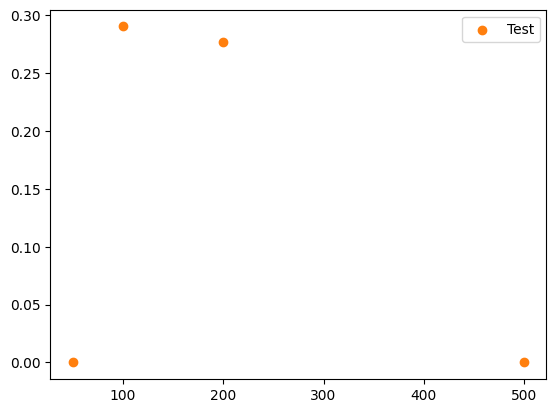

In [ ]:
fig, ax = plt.subplots()
#ax.scatter(results['n_questions'], results['f1_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['f1_test'], color='C1', label='Test')
#plt.yscale('log')
plt.legend()
plt.show()

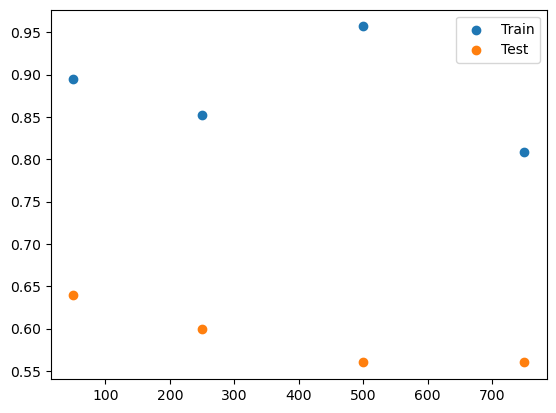

In [ ]:

fig, ax = plt.subplots()
ax.scatter(results['n_questions'], results['Recall_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['Recall_test'], color='C1', label='Test')
plt.legend()
plt.show()

In [ ]:

batch = next(iter(train_dataloader))        

inputs, labels = batch

input_year, input_seq = inputs
bs, ss = labels.size(0), 14
print(input_seq.shape)
input_seq = input_seq.reshape(bs * ss, -1)

print(input_seq.shape)


torch.Size([16, 14, 385])
torch.Size([224, 385])


In [ ]:
next(iter(train_dataloader))[0][1].shape[-1]


385